In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp '/content/kaggle.json' ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download adhoppin/blood-cell-detection-datatset/

 93% 11.0M/11.8M [00:00<00:00, 14.4MB/s]
100% 11.8M/11.8M [00:00<00:00, 12.8MB/s]


In [ ]:
! unzip /content/blood-cell-detection-datatset.zip -d '/content'

Archive:  /content/blood-cell-detection-datatset.zip
  inflating: /content/LICENSE        
  inflating: /content/README.dataset.txt  
  inflating: /content/README.md      
  inflating: /content/data.yaml      
  inflating: /content/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg  
  inflating: /content/test/images/BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg  
  inflating: /content/test/images/BloodImage_00062_jpg.rf.1be1ca0ecdf783798fc10346baaa203e.jpg  
  inflating: /content/test/images/BloodImage_00090_jpg.rf.cdbf8f6ed3b93fa902a0bc991132cb40.jpg  
  inflating: /content/test/images/BloodImage_00099_jpg.rf.e3c42cd68359527494a53843479dff5c.jpg  
  inflating: /content/test/images/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg  
  inflating: /content/test/images/BloodImage_00113_jpg.rf.a17463f1ddc2e7729f935f8a74bc86a4.jpg  
  inflating: /content/test/images/BloodImage_00120_jpg.rf.6725d54bf5615683448eb1de4c7577ee.jpg  
  inflating: /

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

In [ ]:
import yaml
from ultralytics import YOLO

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter

In [ ]:
!cat ../content/data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['Platelets', 'RBC', 'WBC']

In [ ]:
ls -1 /content/train/images | wc -l

765


In [ ]:
ls -1 /content/test/images | wc -l

36


In [ ]:
ls -1 /content/valid/images | wc -l

73


In [ ]:
# Load the YAML file
with open('../content/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

# update YAML with absolute path to kaggle data.
data_yaml['train'] = '/content/train/images'
data_yaml['val'] = '/content/valid/images'

# write to disk
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [ ]:
data_dir = Path("../content/")
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = data_yaml['names']

# Read the image file paths and annotations
image_paths = list(images_dir.glob("*.jpg"))
label_paths = sorted(labels_dir.glob("*.txt"))

In [ ]:
resolutions = []

for image_path in image_paths:
    img = cv2.imread(str(image_path))
    h, w, _ = img.shape
    resolutions.append((w, h))

unique_resolutions = set(resolutions)
print("Unique resolutions:", unique_resolutions)

Unique resolutions: {(416, 416)}


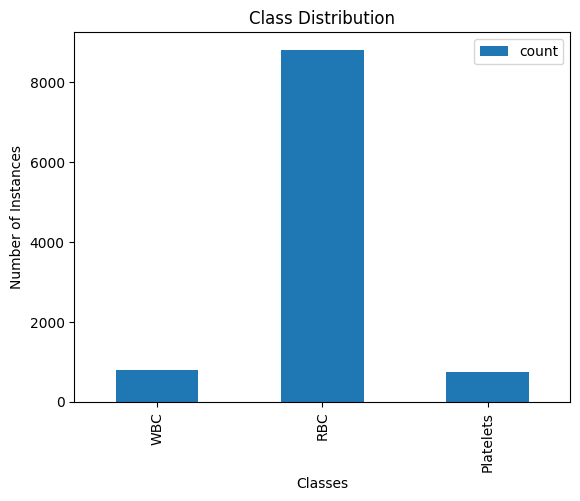

In [ ]:
class_counts = Counter()
for label_file in label_paths:
    with open(label_file, "r") as file:
        lines = file.readlines()
    class_counts.update(Counter([int(line.split()[0]) for line in lines]))

# Replace class IDs with class names
class_counts_names = {class_names[int(class_id)]: count for class_id, count in class_counts.items()}

# Create a pandas DataFrame and plot the bar chart
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
ax = df.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()

In [ ]:
data = []

for file in label_paths:
    with open(file) as f:
        lines = f.readlines()
        num_lines = len(lines)
        unique_values = len(set(list(map(lambda x: x.split()[0], lines))))

        data.append([file, num_lines, unique_values])

df = pd.DataFrame(data, columns=['file', 'num_lines', 'unique_values'])

<Axes: >

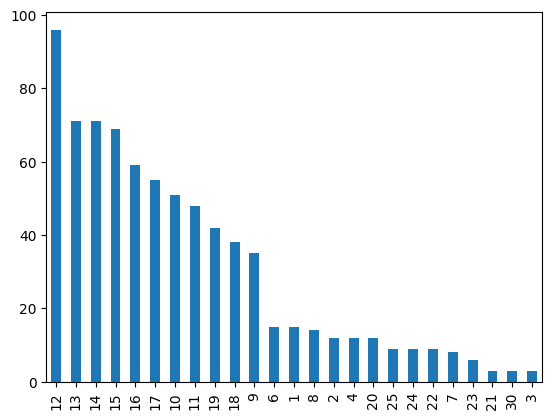

In [ ]:
# distribution of number of detections in an image
df['num_lines'].value_counts().plot(kind='bar')

<Axes: >

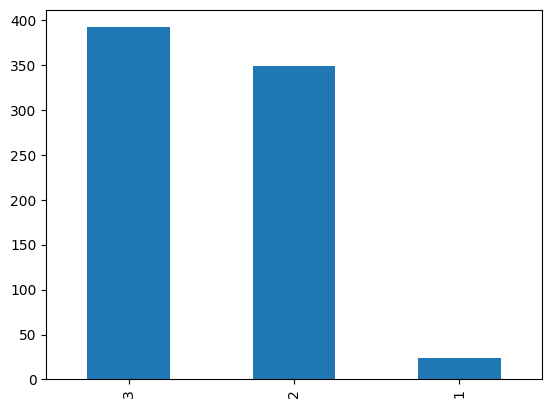

In [ ]:
# distribution of number of unique classes in images
df['unique_values'].value_counts().plot(kind='bar')

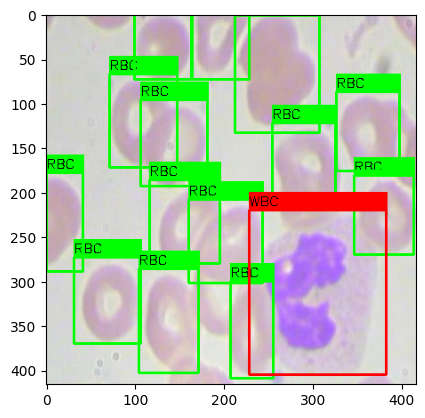

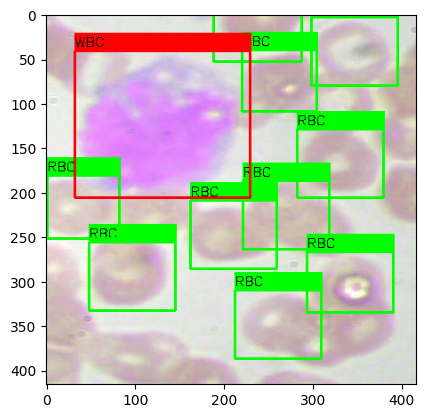

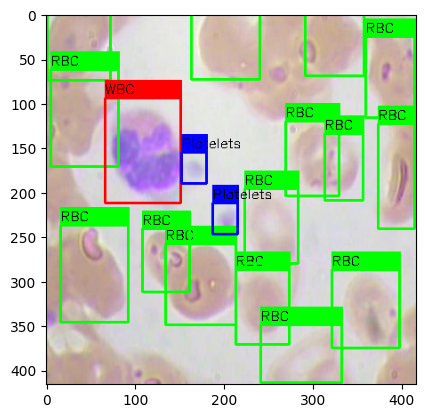

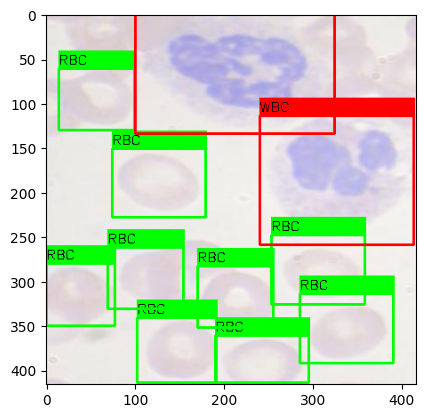

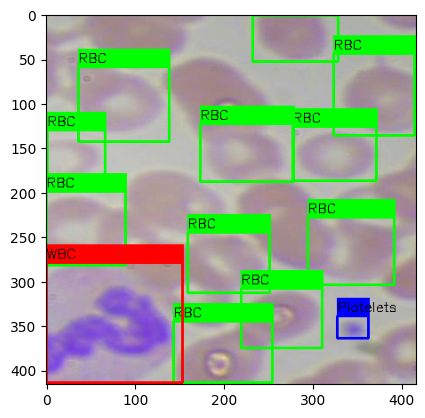

In [ ]:
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

In [ ]:
# # clone YOLOv5 repository
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5
# !git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

Cloning into 'yolov5'...
remote: Enumerating objects: 16078, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 16078 (delta 6), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16078/16078), 14.64 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (11038/11038), done.
/content/yolov5
HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [ ]:
model = YOLO('yolov5x.pt')
results = model.train(data='/content/data.yaml', epochs=30, batch = 8)

PRO TIP 💡 Replace 'model=yolov5x.pt' with new 'model=yolov5xu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 186M/186M [00:00<00:00, 406MB/s]


Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5x.pt, data=/content/data.yaml, epochs=30, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, ke

100%|██████████| 755k/755k [00:00<00:00, 110MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      8800  ultralytics.nn.modules.conv.Conv             [3, 80, 6, 2, 2]              
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  4    309120  ultralytics.nn.modules.block.C3              [160, 160, 4]                 
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  8   2259200  ultralytics.nn.modules.block.C3              [320, 320, 8]                 
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1 12  13125120  ultralytics.nn.modules.block.C3              [640, 640, 12]                
  7                  -1  1   7375360  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 316MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:00<00:00, 1120.93it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 860.63it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 135 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.43G      1.347       1.39      1.551         70        640: 100%|██████████| 96/96 [01:02<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all         73        967      0.634      0.834      0.788      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      8.72G      1.301      1.092      1.466        116        640: 100%|██████████| 96/96 [01:02<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all         73        967      0.749      0.896      0.874      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.74G      1.296       1.07      1.473        101        640: 100%|██████████| 96/96 [01:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all         73        967      0.673      0.911      0.872      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      8.79G      1.263      1.019      1.451         99        640: 100%|██████████| 96/96 [01:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all         73        967      0.783      0.913      0.895      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      8.75G      1.243     0.9905      1.431        123        640: 100%|██████████| 96/96 [01:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all         73        967      0.711      0.664      0.696       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      8.73G       1.25     0.9766      1.427        132        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all         73        967      0.795      0.817       0.87      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      8.66G       1.22     0.9486      1.398        103        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all         73        967      0.801      0.853      0.873      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      8.69G      1.201     0.9352      1.384        135        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all         73        967      0.758       0.85      0.853      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      8.71G      1.185     0.9001      1.364         72        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all         73        967      0.556      0.655      0.632      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      8.66G      1.175     0.8949       1.36        125        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all         73        967      0.797      0.878      0.894      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.68G      1.174     0.8712      1.359         62        640: 100%|██████████| 96/96 [01:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all         73        967      0.827      0.896      0.903      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      8.68G      1.172     0.8744      1.359         88        640: 100%|██████████| 96/96 [01:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]

                   all         73        967      0.816      0.846      0.905      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      8.72G      1.155     0.8585      1.347        122        640: 100%|██████████| 96/96 [01:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all         73        967      0.813      0.921        0.9      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      8.65G      1.152     0.8497      1.346        105        640: 100%|██████████| 96/96 [01:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all         73        967      0.836      0.844      0.893      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      8.69G      1.139     0.8376      1.325         90        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all         73        967      0.839       0.92      0.915       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      8.68G      1.139      0.846      1.339        157        640: 100%|██████████| 96/96 [01:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all         73        967      0.783      0.943      0.904      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      8.71G      1.104     0.7952      1.299        100        640: 100%|██████████| 96/96 [01:02<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all         73        967       0.83      0.921      0.915      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      8.69G       1.11     0.7974      1.297        110        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all         73        967      0.836      0.933      0.922      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      8.72G      1.104     0.7955       1.29        161        640: 100%|██████████| 96/96 [01:02<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all         73        967      0.818      0.902      0.913      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      8.66G      1.109     0.7948      1.304        107        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all         73        967      0.857      0.914      0.925      0.636


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.64G      1.116     0.7603      1.338         54        640: 100%|██████████| 96/96 [01:03<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all         73        967      0.857      0.899      0.922      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      8.65G        1.1     0.7453      1.332         69        640: 100%|██████████| 96/96 [01:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

                   all         73        967      0.833      0.913       0.91      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      8.62G      1.105     0.7328      1.328         59        640: 100%|██████████| 96/96 [01:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

                   all         73        967      0.823      0.922      0.915      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      8.65G      1.089     0.7348      1.323         74        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all         73        967      0.843       0.91      0.914      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      8.66G      1.074     0.7199      1.315         71        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all         73        967      0.784      0.909      0.908      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      8.66G      1.069     0.6968      1.295         38        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all         73        967       0.86      0.876      0.918      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      8.68G      1.062     0.6985      1.279         56        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all         73        967      0.854      0.904      0.922      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      8.68G      1.053     0.6878      1.291         59        640: 100%|██████████| 96/96 [01:02<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]

                   all         73        967      0.834      0.929      0.927      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      8.65G      1.039     0.6678      1.277         65        640: 100%|██████████| 96/96 [01:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]

                   all         73        967       0.85      0.911      0.926      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      8.68G      1.035     0.6678      1.278         74        640: 100%|██████████| 96/96 [01:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all         73        967      0.862      0.894      0.924      0.661



30 epochs completed in 0.589 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 195.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 195.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5x summary (fused): 358 layers, 97155497 parameters, 0 gradients, 246.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


                   all         73        967      0.851       0.91      0.926      0.663
             Platelets         73         76      0.827      0.882      0.909       0.51
                   RBC         73        819      0.758      0.846      0.889      0.653
                   WBC         73         72      0.967          1      0.979      0.828
Speed: 1.9ms preprocess, 73.9ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to runs/detect/train


In [ ]:
from ultralytics.utils.metrics import ConfusionMatrix

In [ ]:
metrics = model.val()

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5x summary (fused): 358 layers, 97155497 parameters, 0 gradients, 246.0 GFLOPs


val: Scanning /content/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


                   all         73        967       0.85      0.906      0.926      0.665
             Platelets         73         76      0.826      0.875      0.909      0.515
                   RBC         73        819      0.758      0.844      0.889      0.652
                   WBC         73         72      0.967          1      0.979      0.828
Speed: 0.8ms preprocess, 85.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
print(metrics.confusion_matrix.matrix)

[[         71           0           0          26]
 [          0         767           0         394]
 [          1           0          72           1]
 [          4          52           0           0]]


In [ ]:
from IPython.display import Image

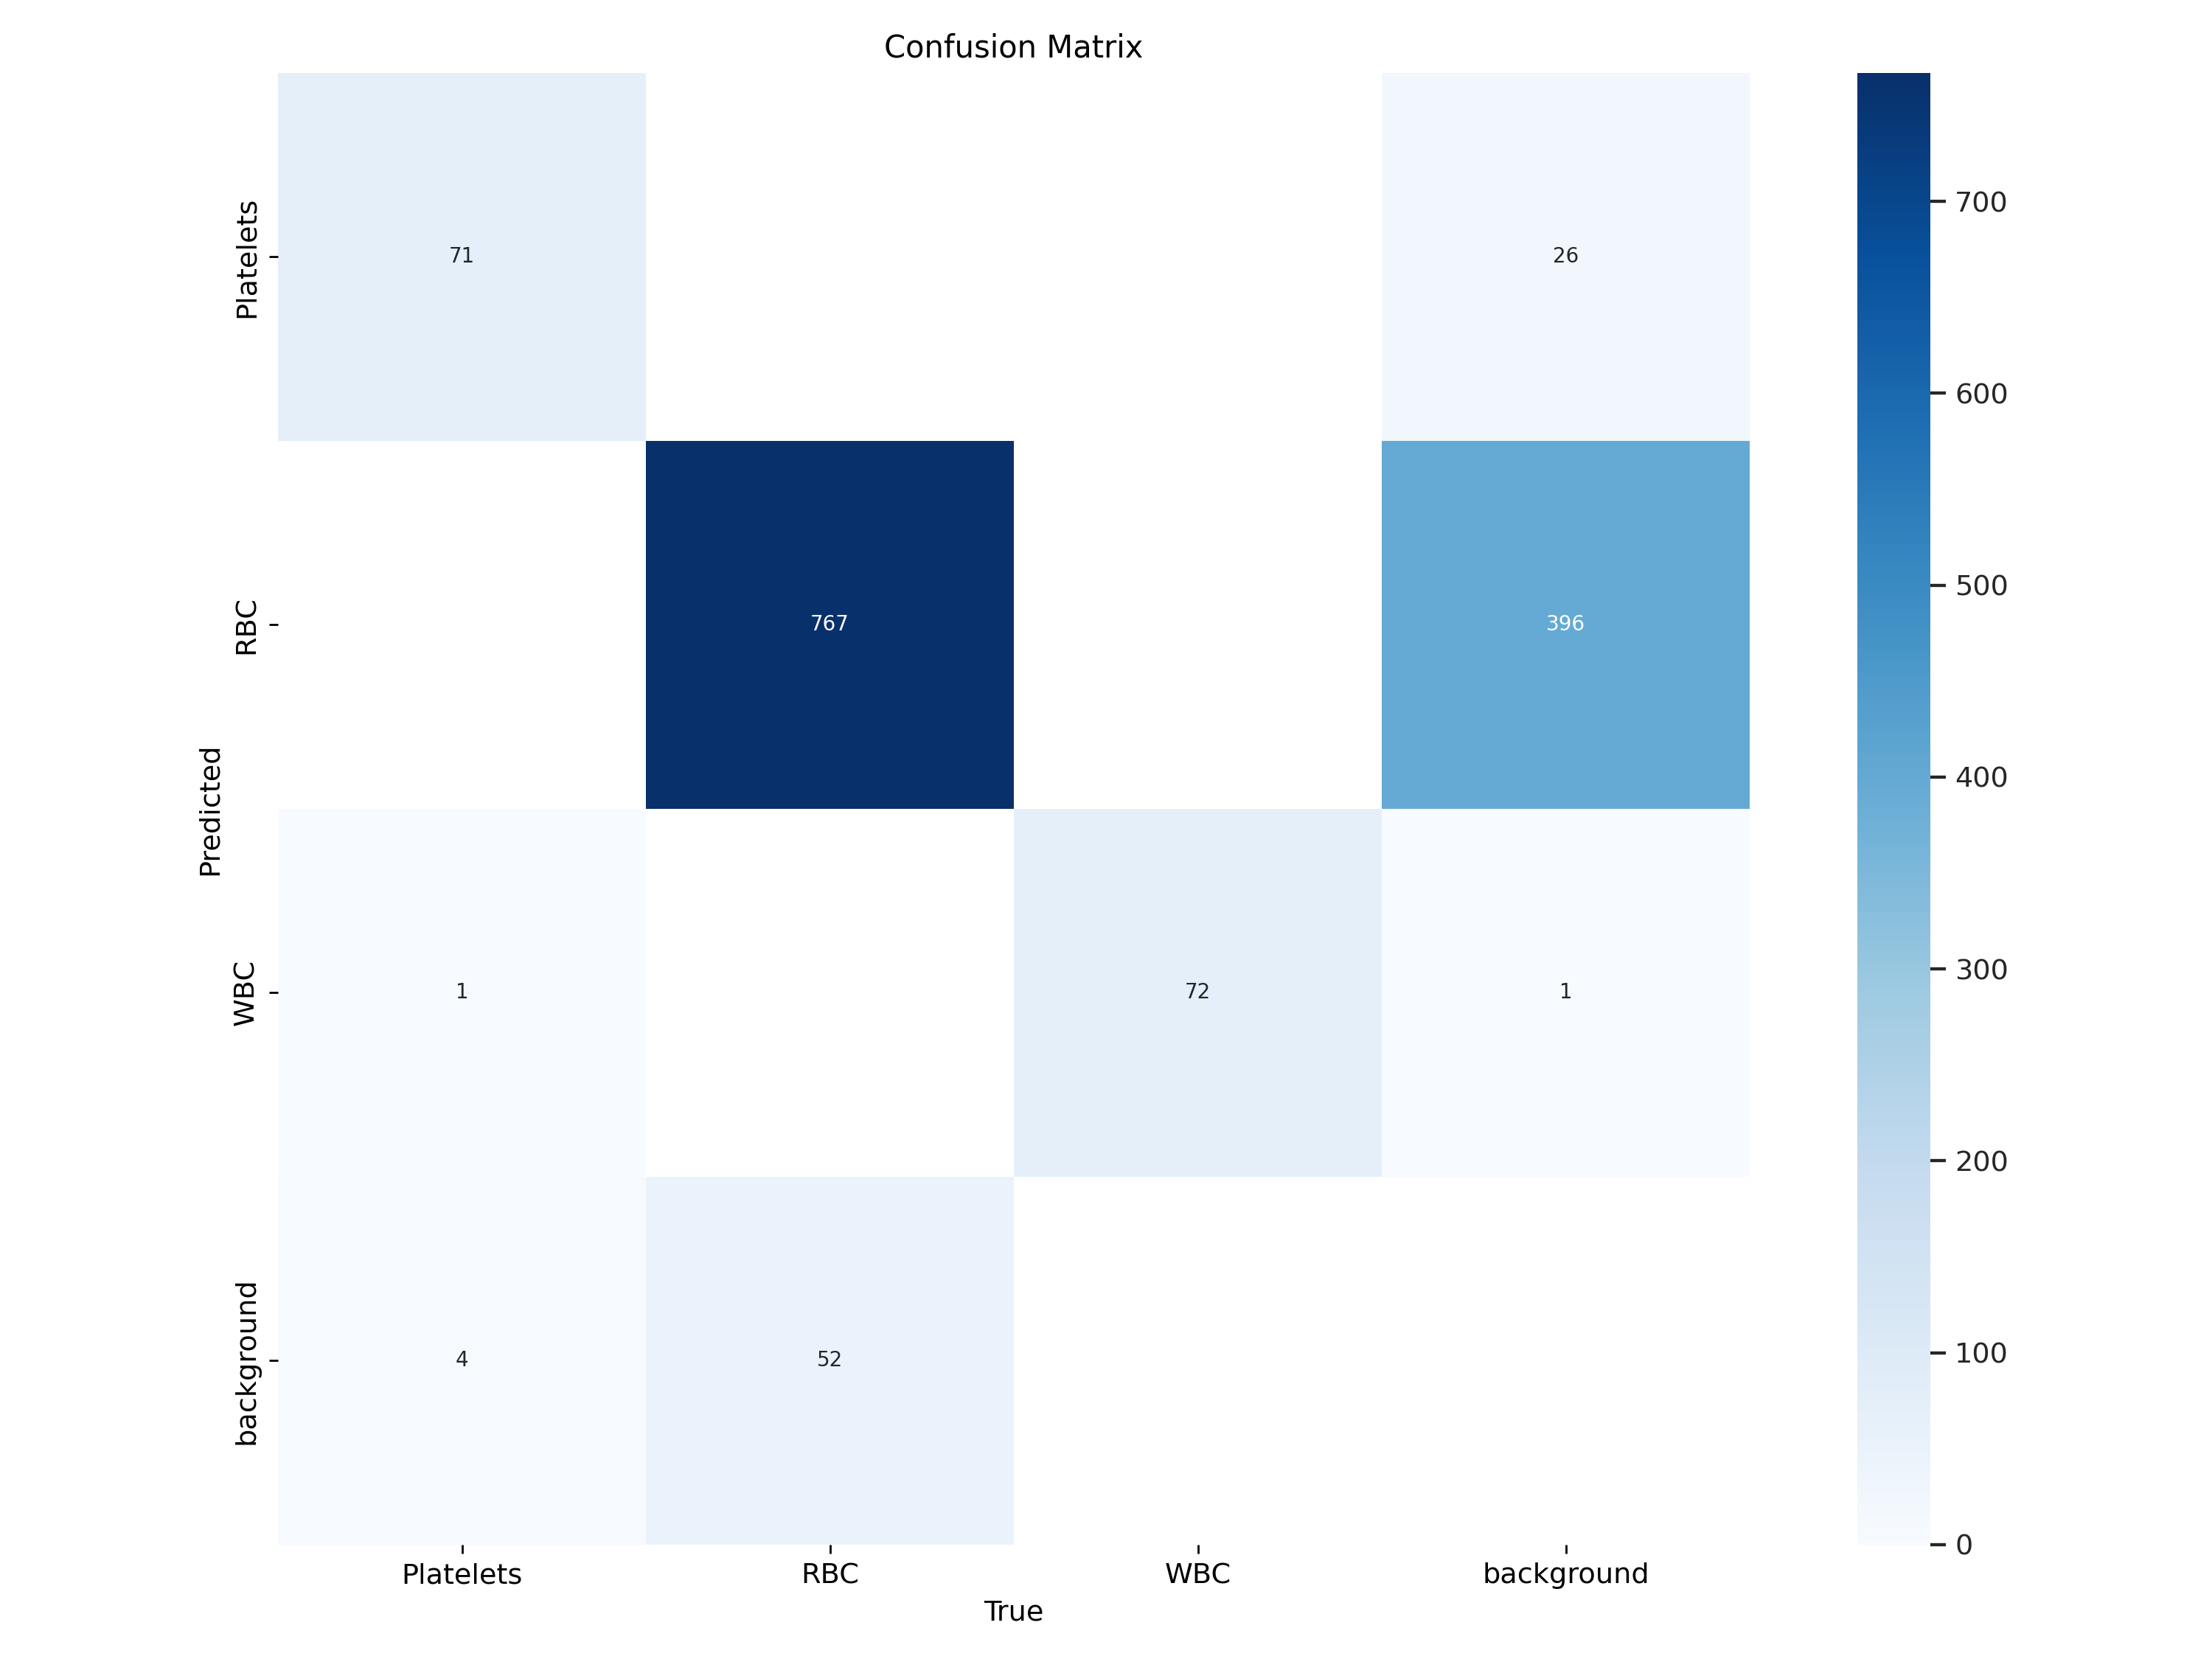

In [ ]:
Image(filename='/content/runs/detect/train/confusion_matrix.png', height=400)

In [ ]:
conf_mat = metrics.confusion_matrix.matrix

# Calculate IoU
iou = np.diag(conf_mat) / (conf_mat.sum(axis=1) + conf_mat.sum(axis=0) - np.diag(conf_mat))

# Calculate Dice coefficient
dice_coefficient = (2 * np.diag(conf_mat)) / (conf_mat.sum(axis=0) + conf_mat.sum(axis=1))

print(f'Test IoU: {np.mean(iou):.4f}')
print(f'Test Dice Coefficient: {np.mean(dice_coefficient):.4f}')

Test IoU: 0.5753
Test Dice Coefficient: 0.6455


In [ ]:
print(metrics.box.map75)

0.7537344077979121


In [ ]:
print(metrics.box.f1)

[    0.84975     0.79856     0.98335]


GROUND TRUTH TRAINING DATA:


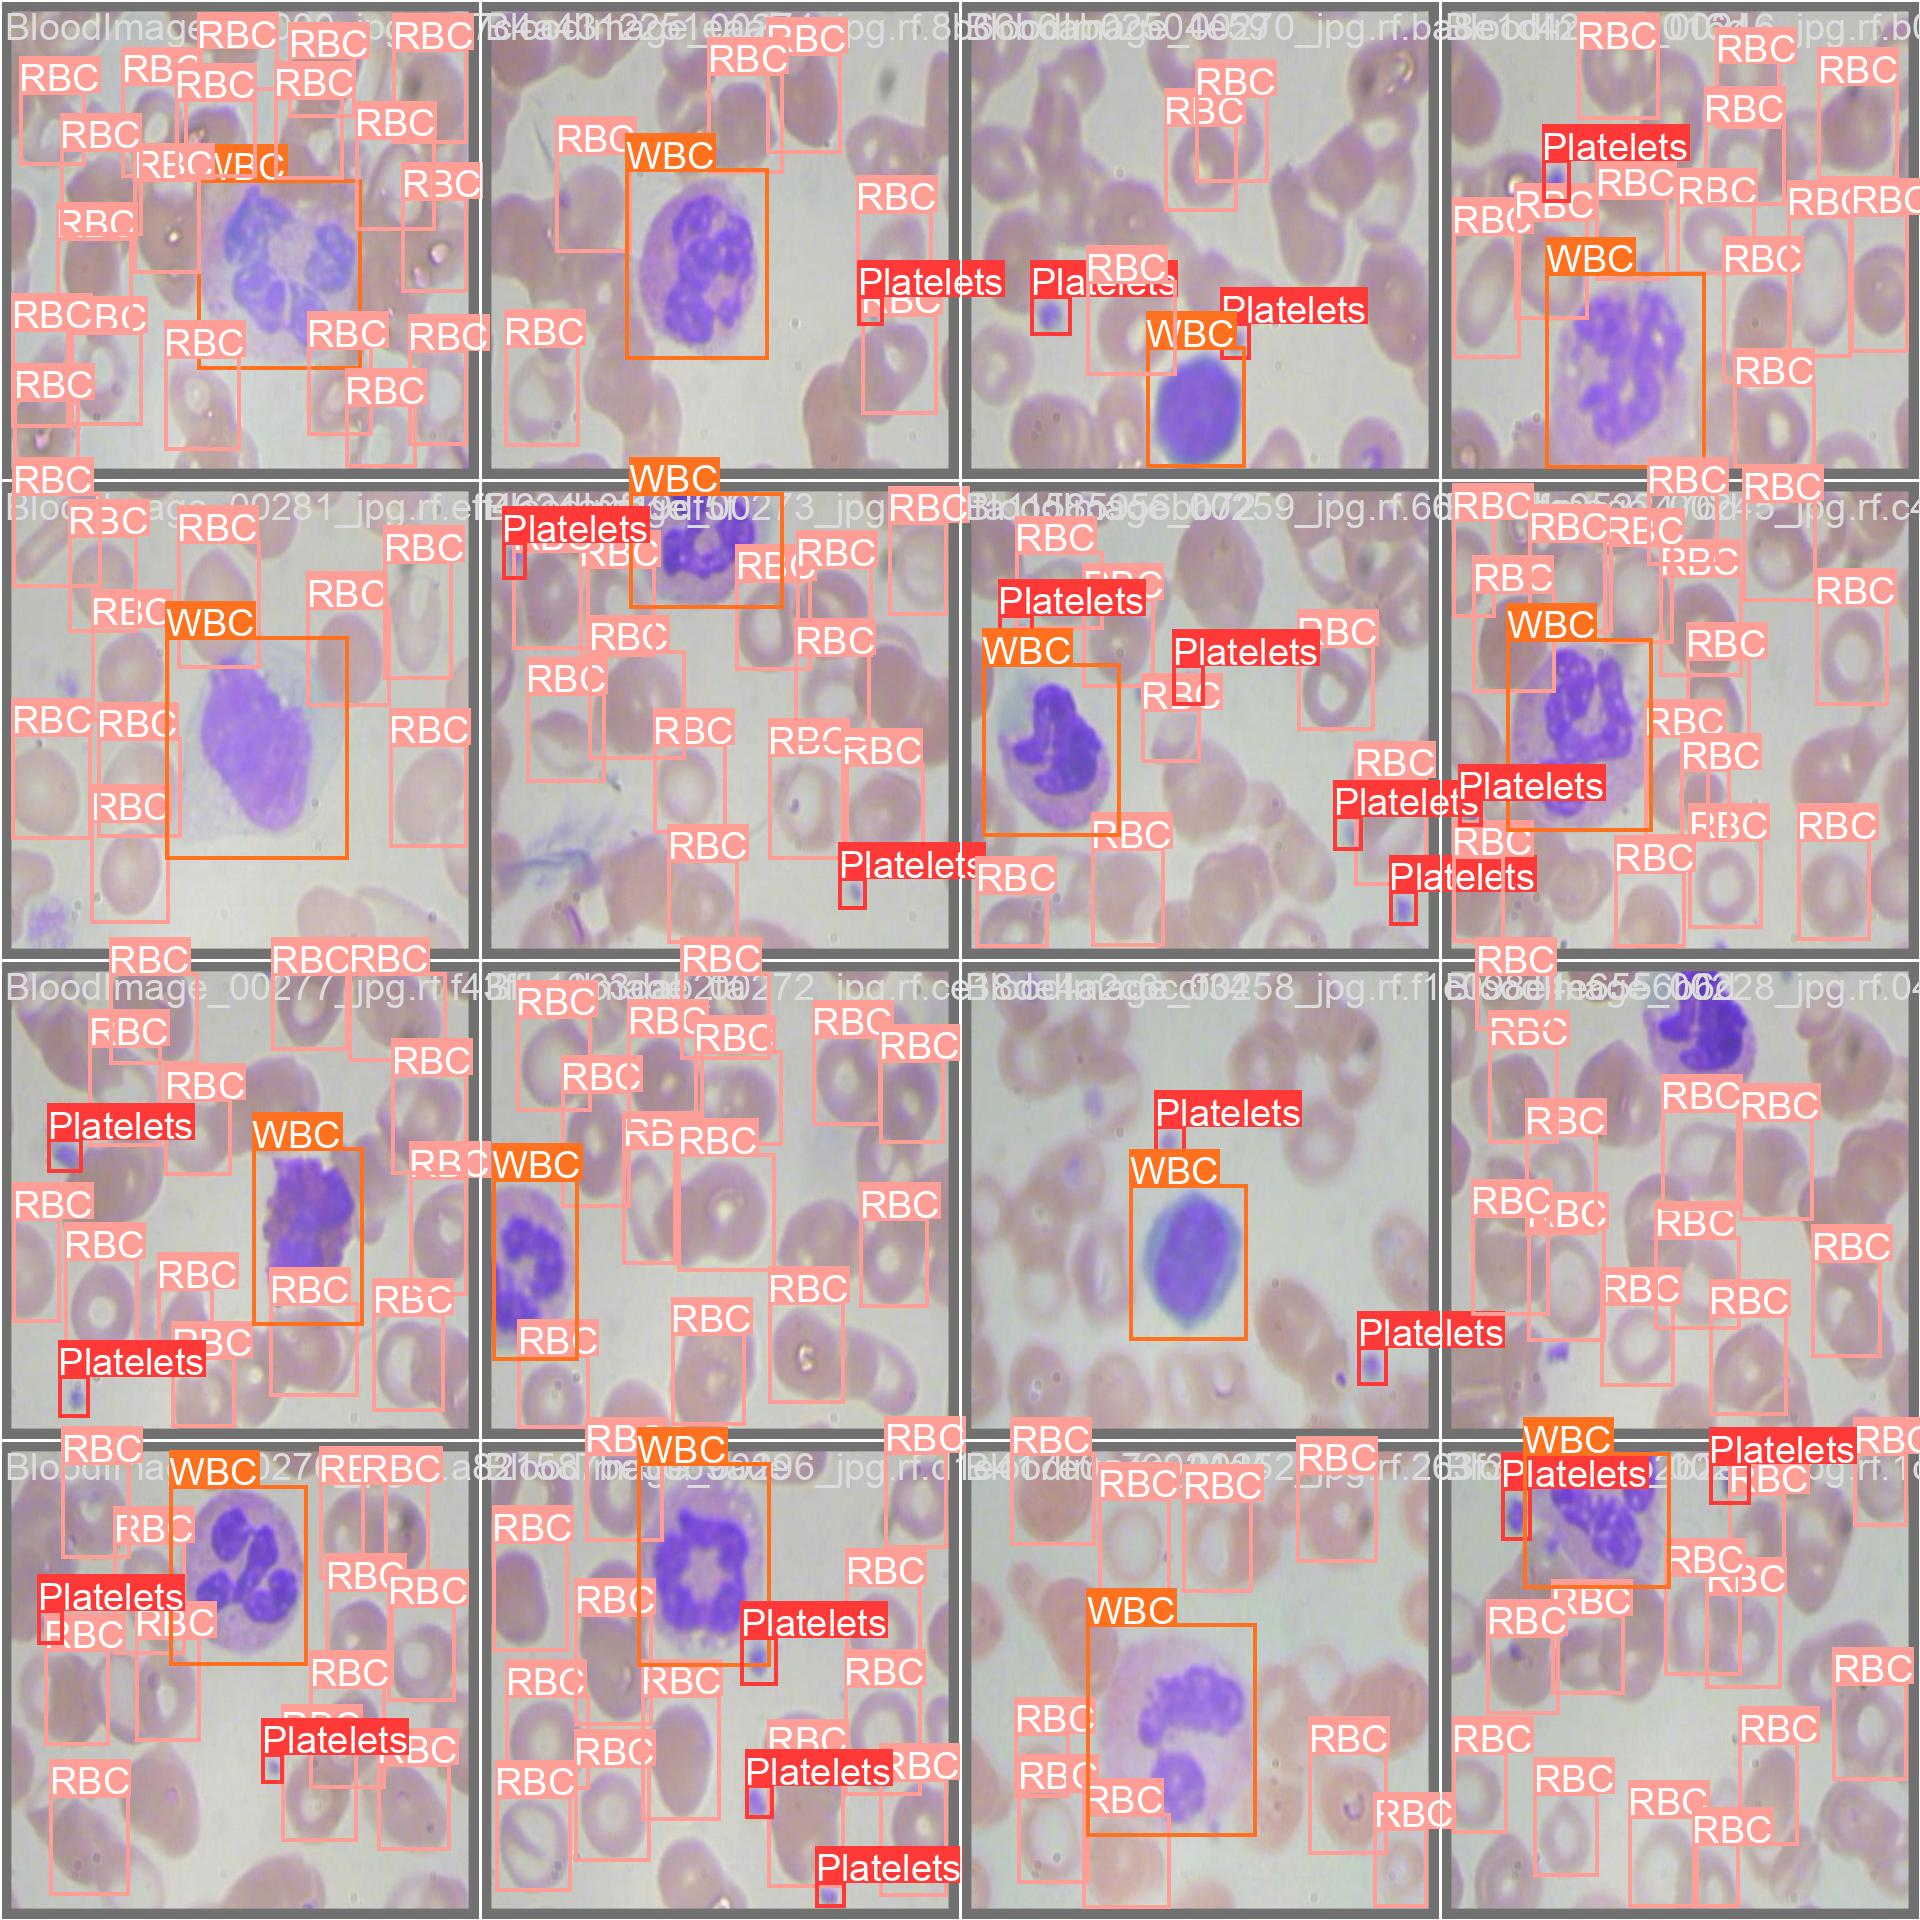

In [ ]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/runs/detect/train/val_batch0_labels.jpg', width=900)

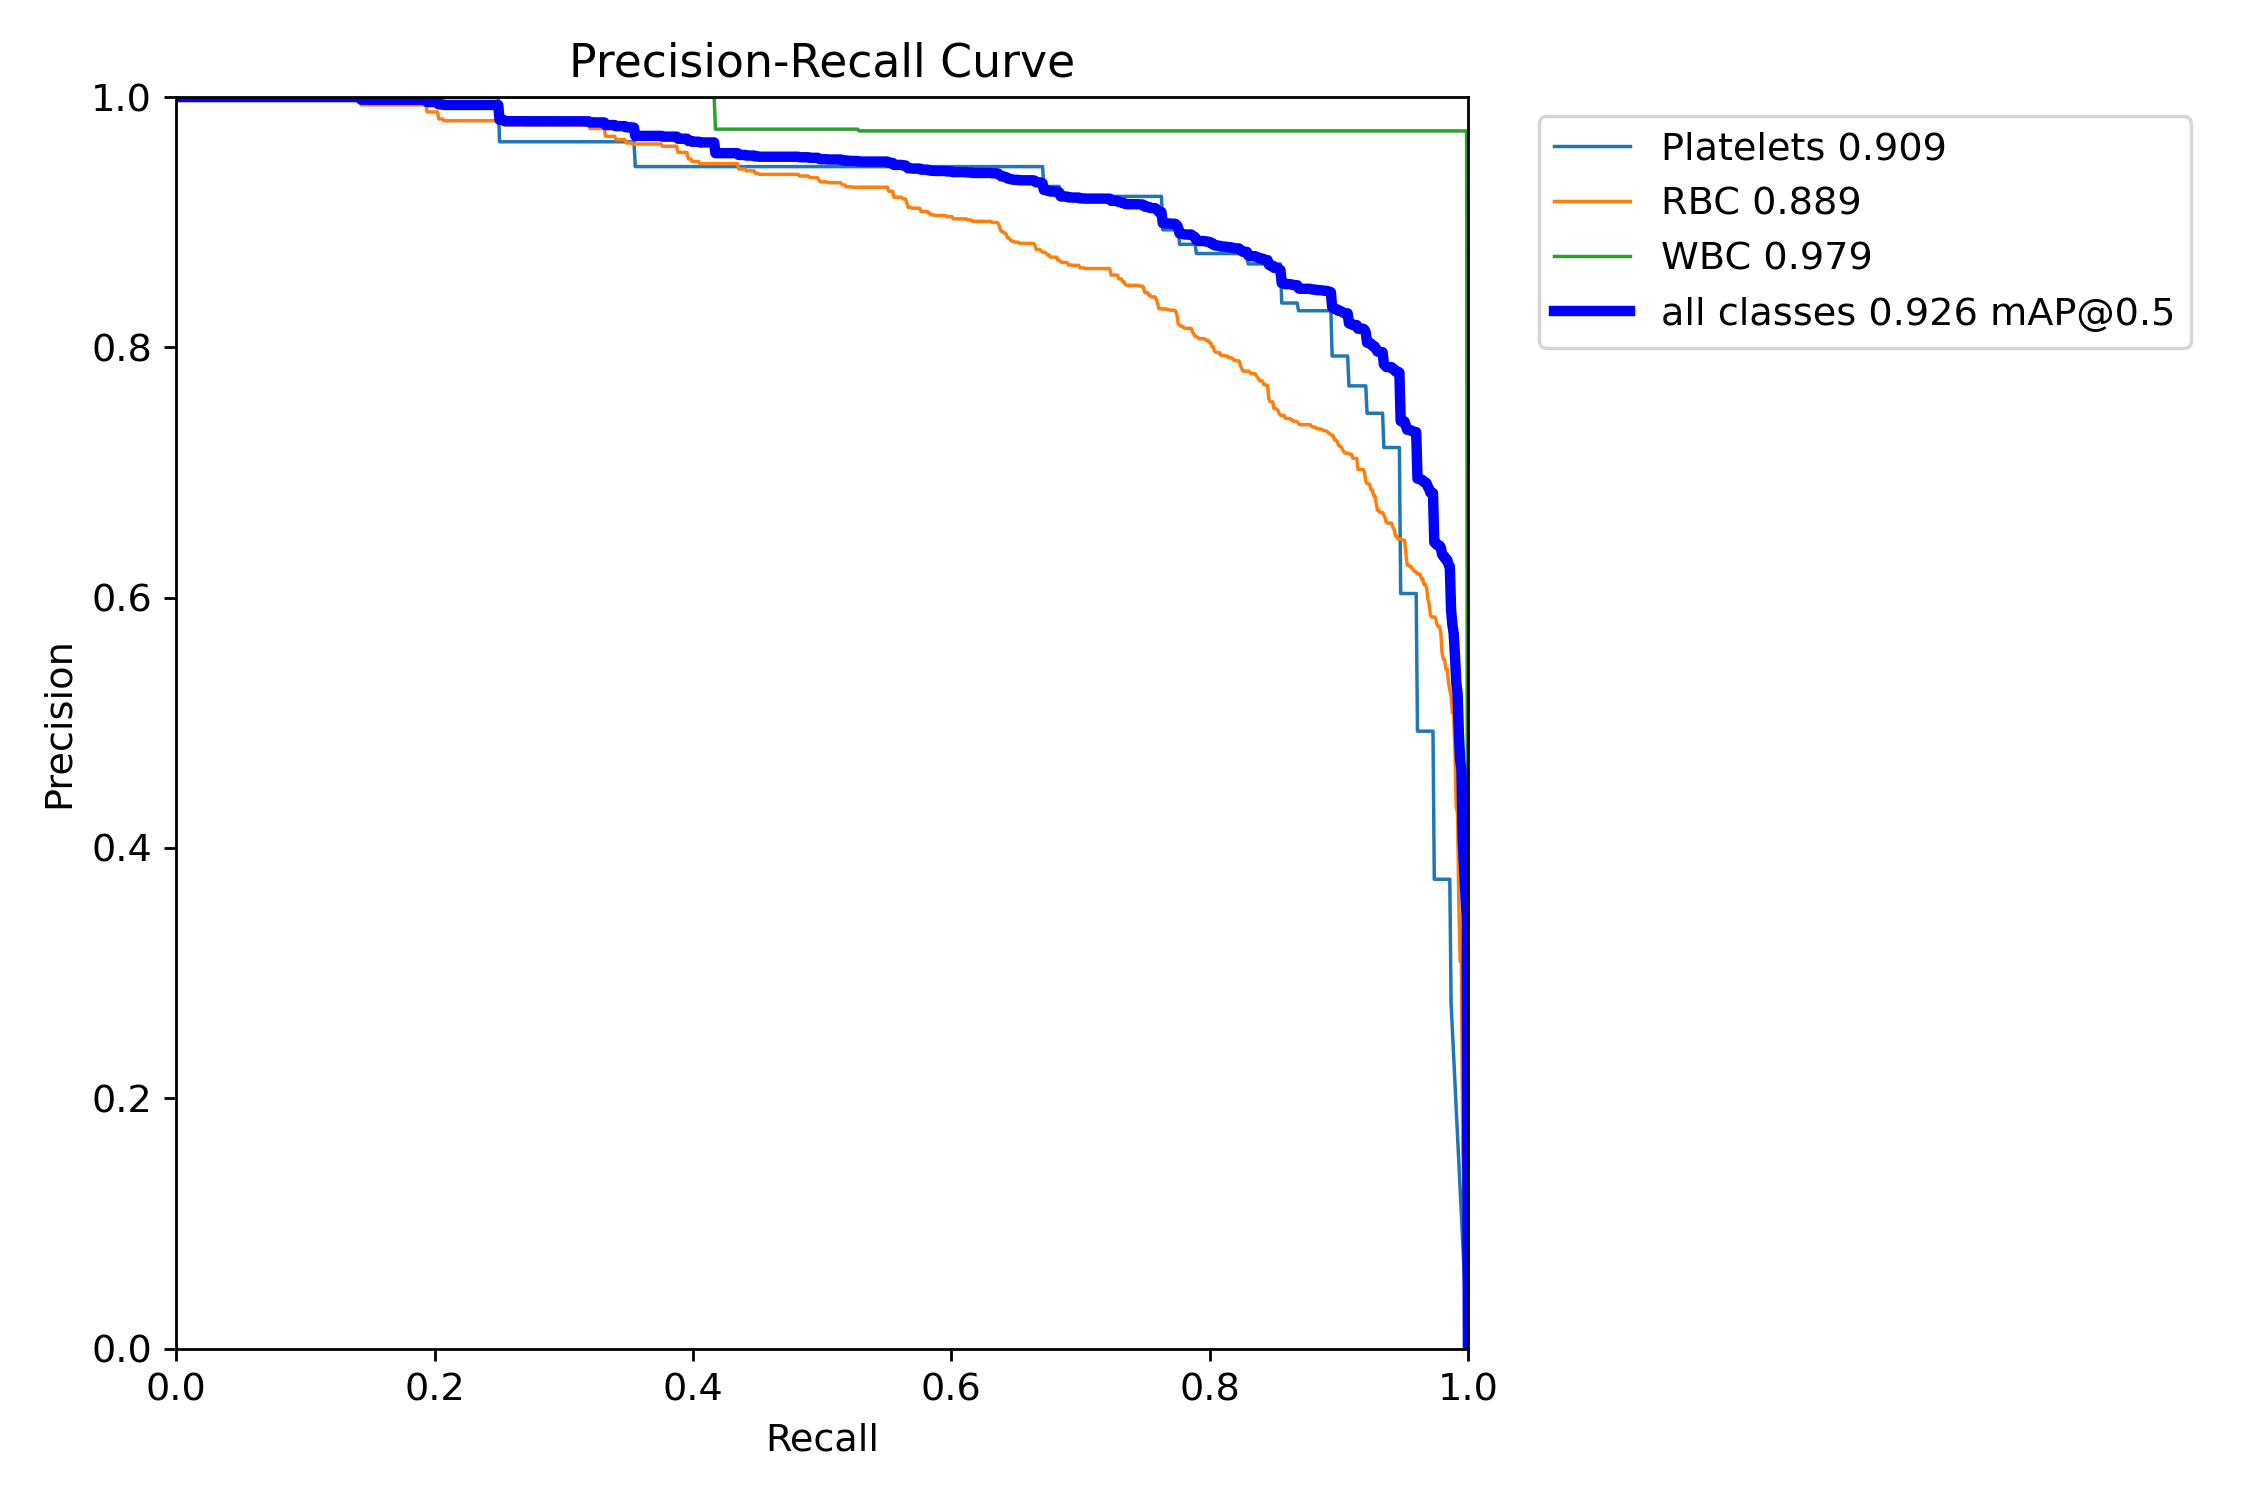

In [ ]:
Image(filename='/content/runs/detect/train/PR_curve.png', height=400)

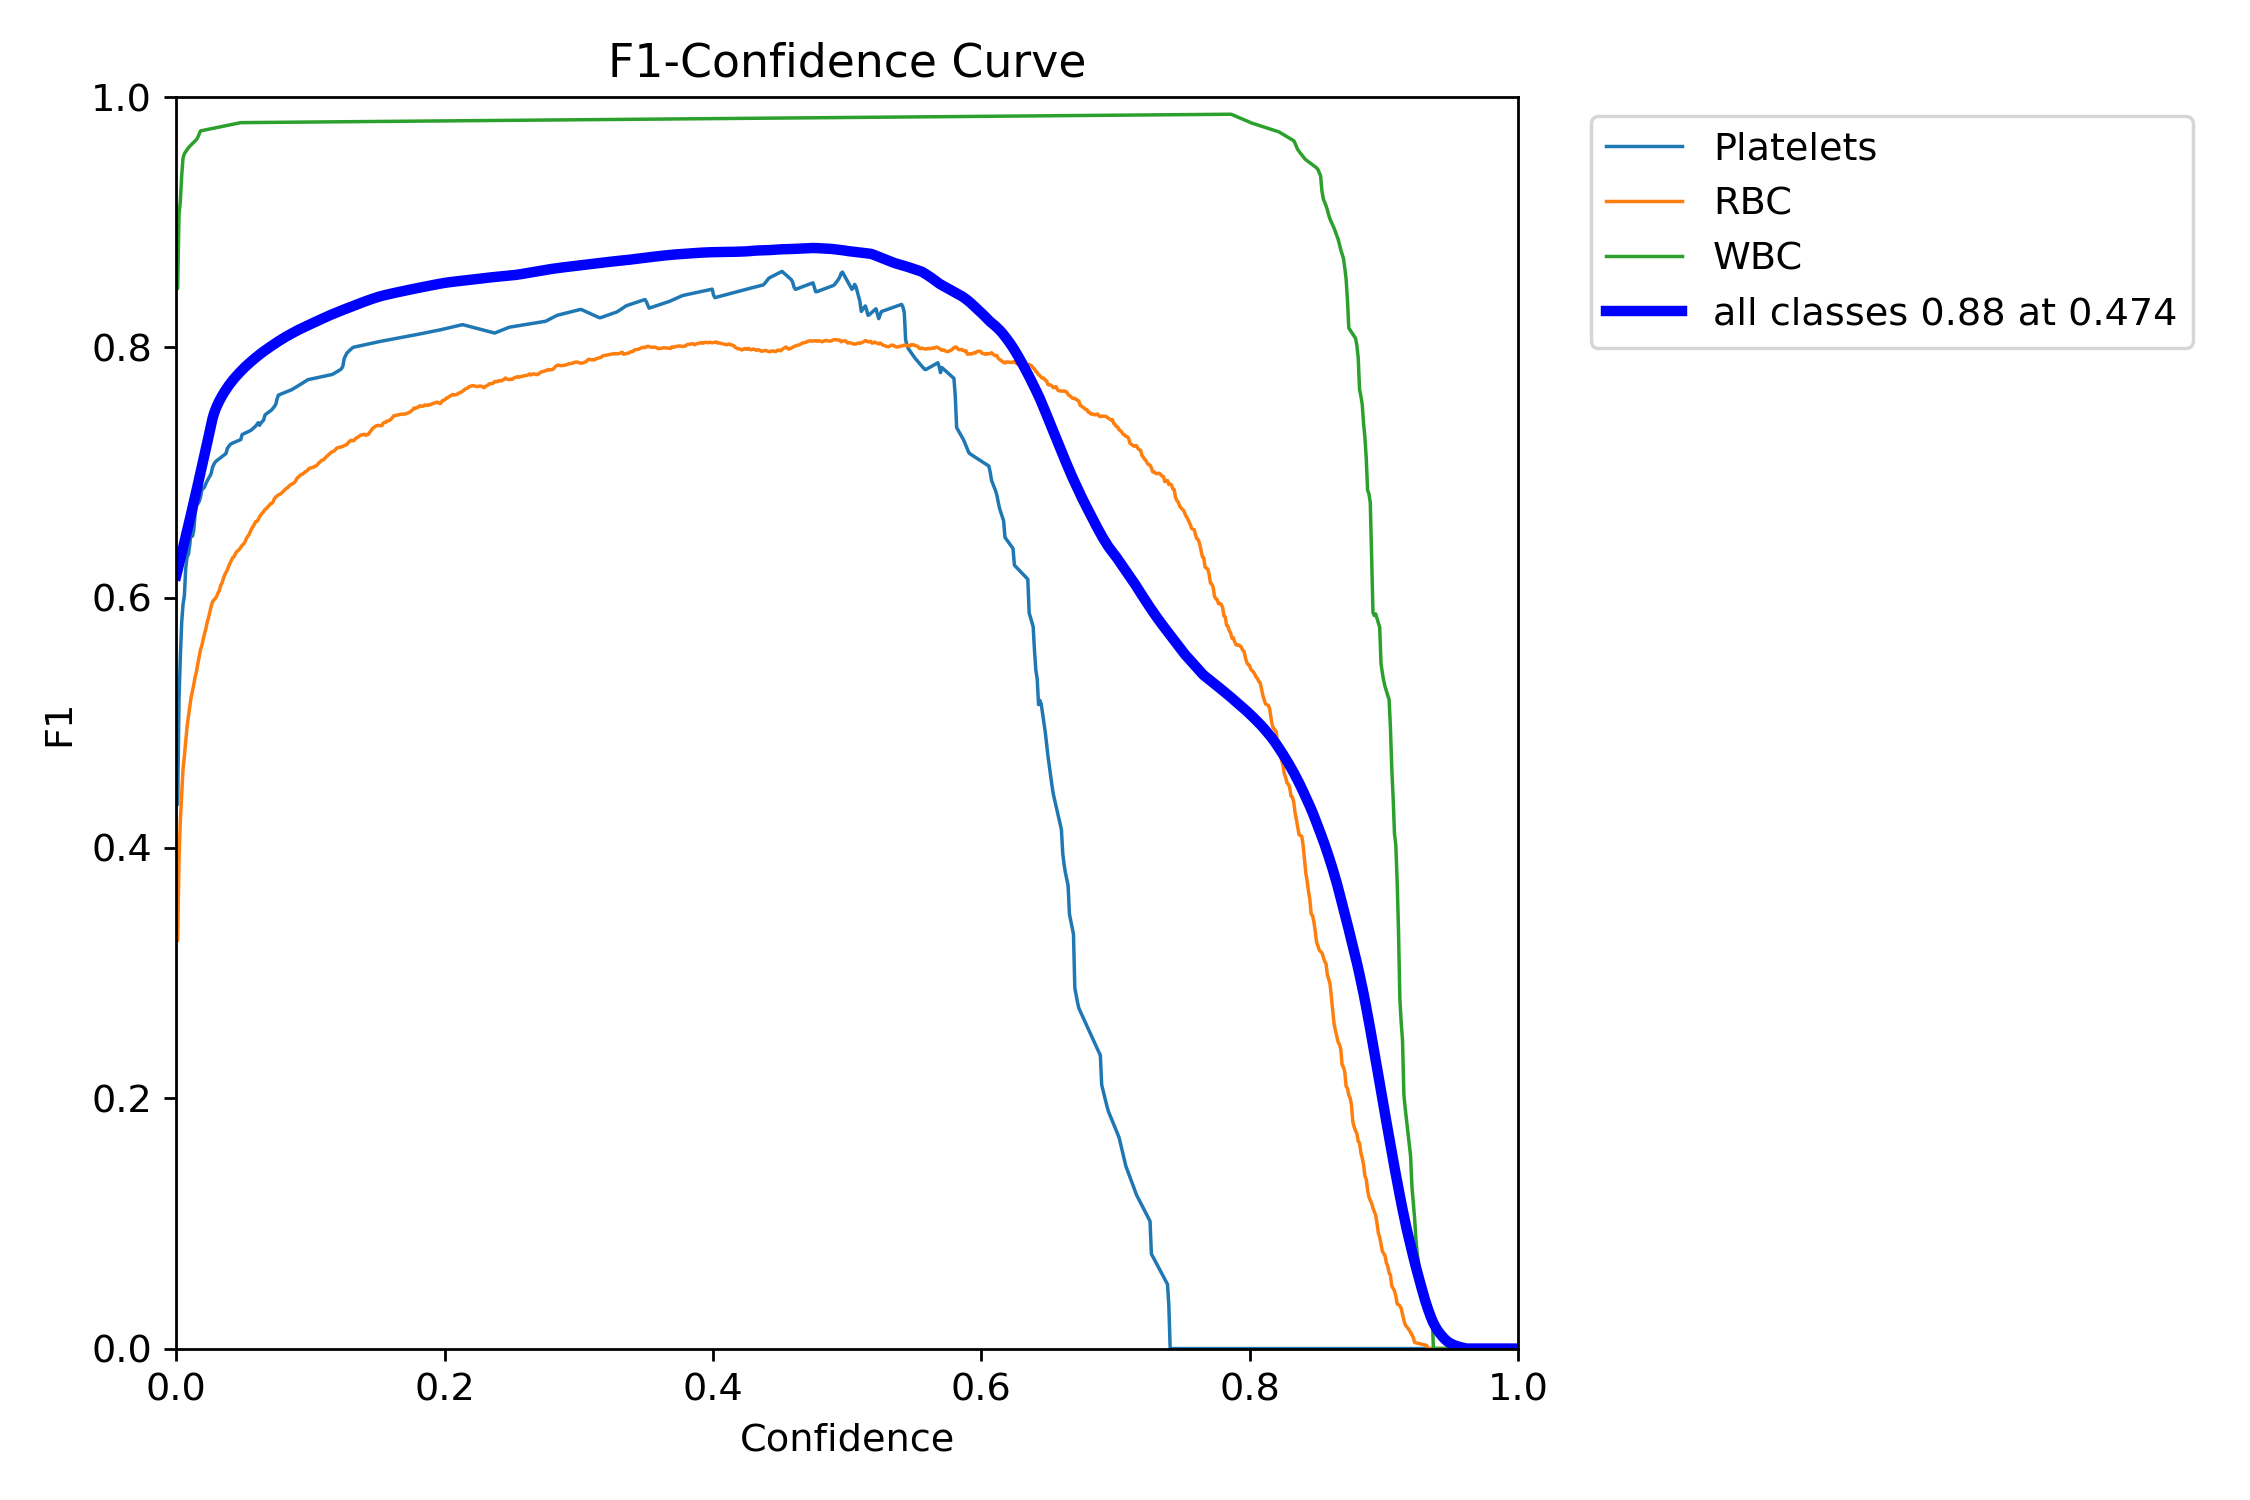

In [ ]:
Image(filename='/content/runs/detect/train/F1_curve.png', height=400)

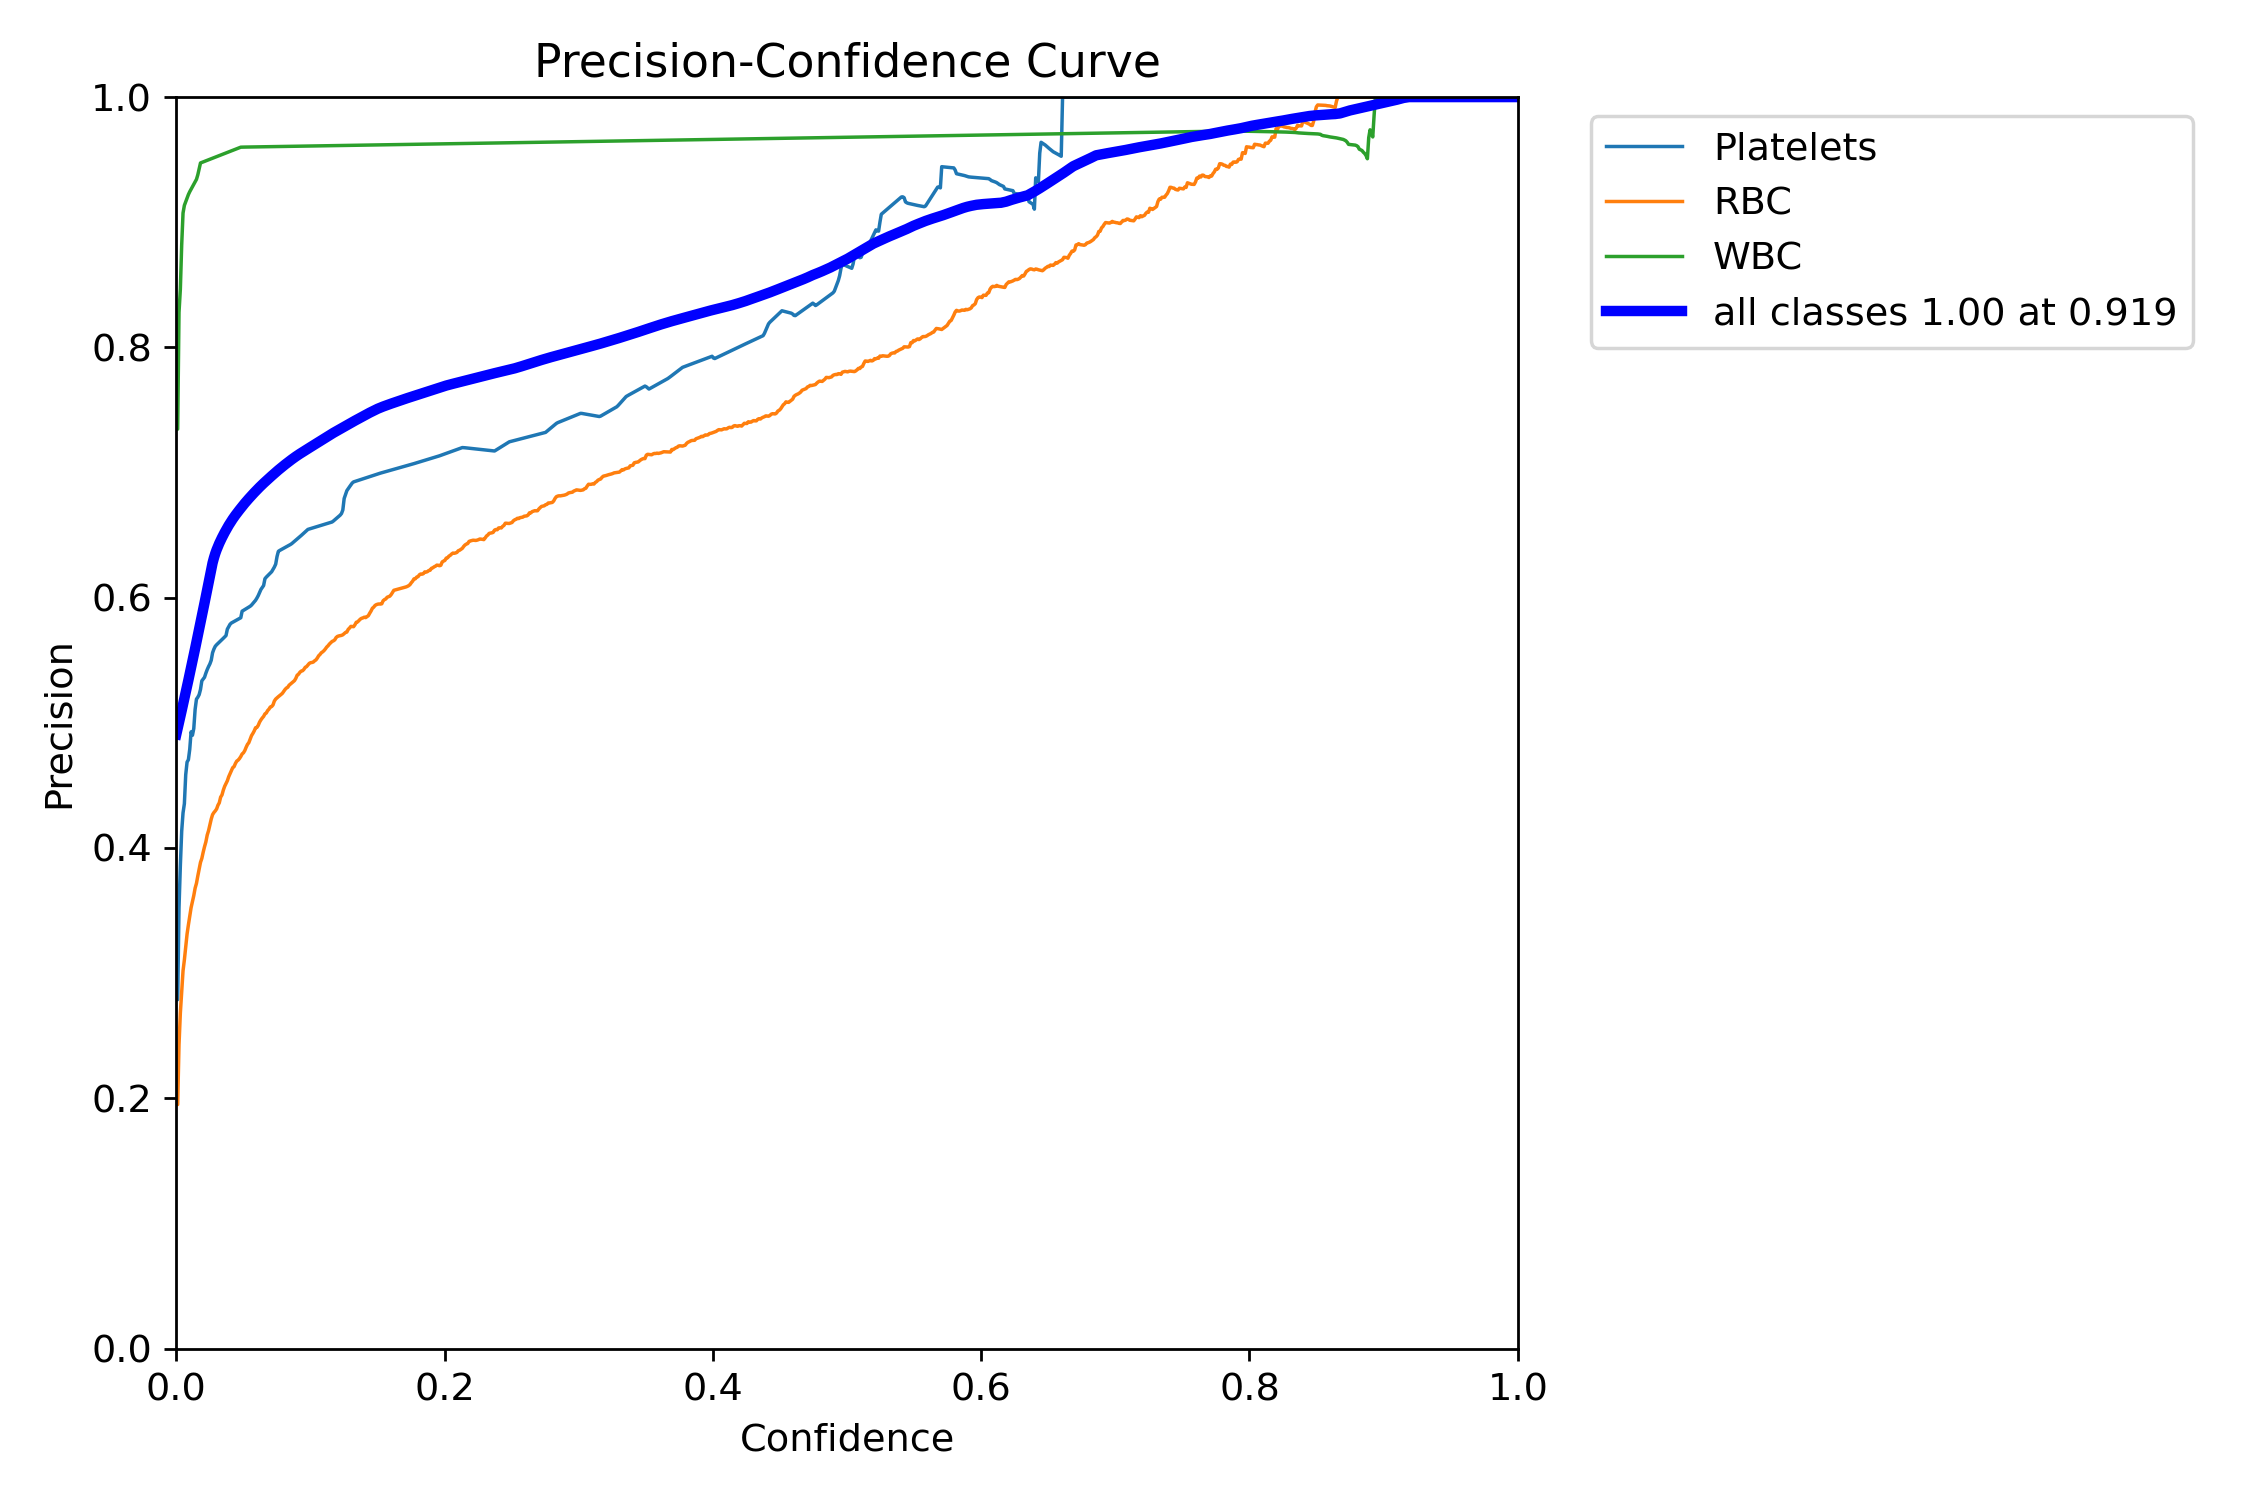

In [ ]:
Image(filename='/content/runs/detect/train/P_curve.png', height=400)

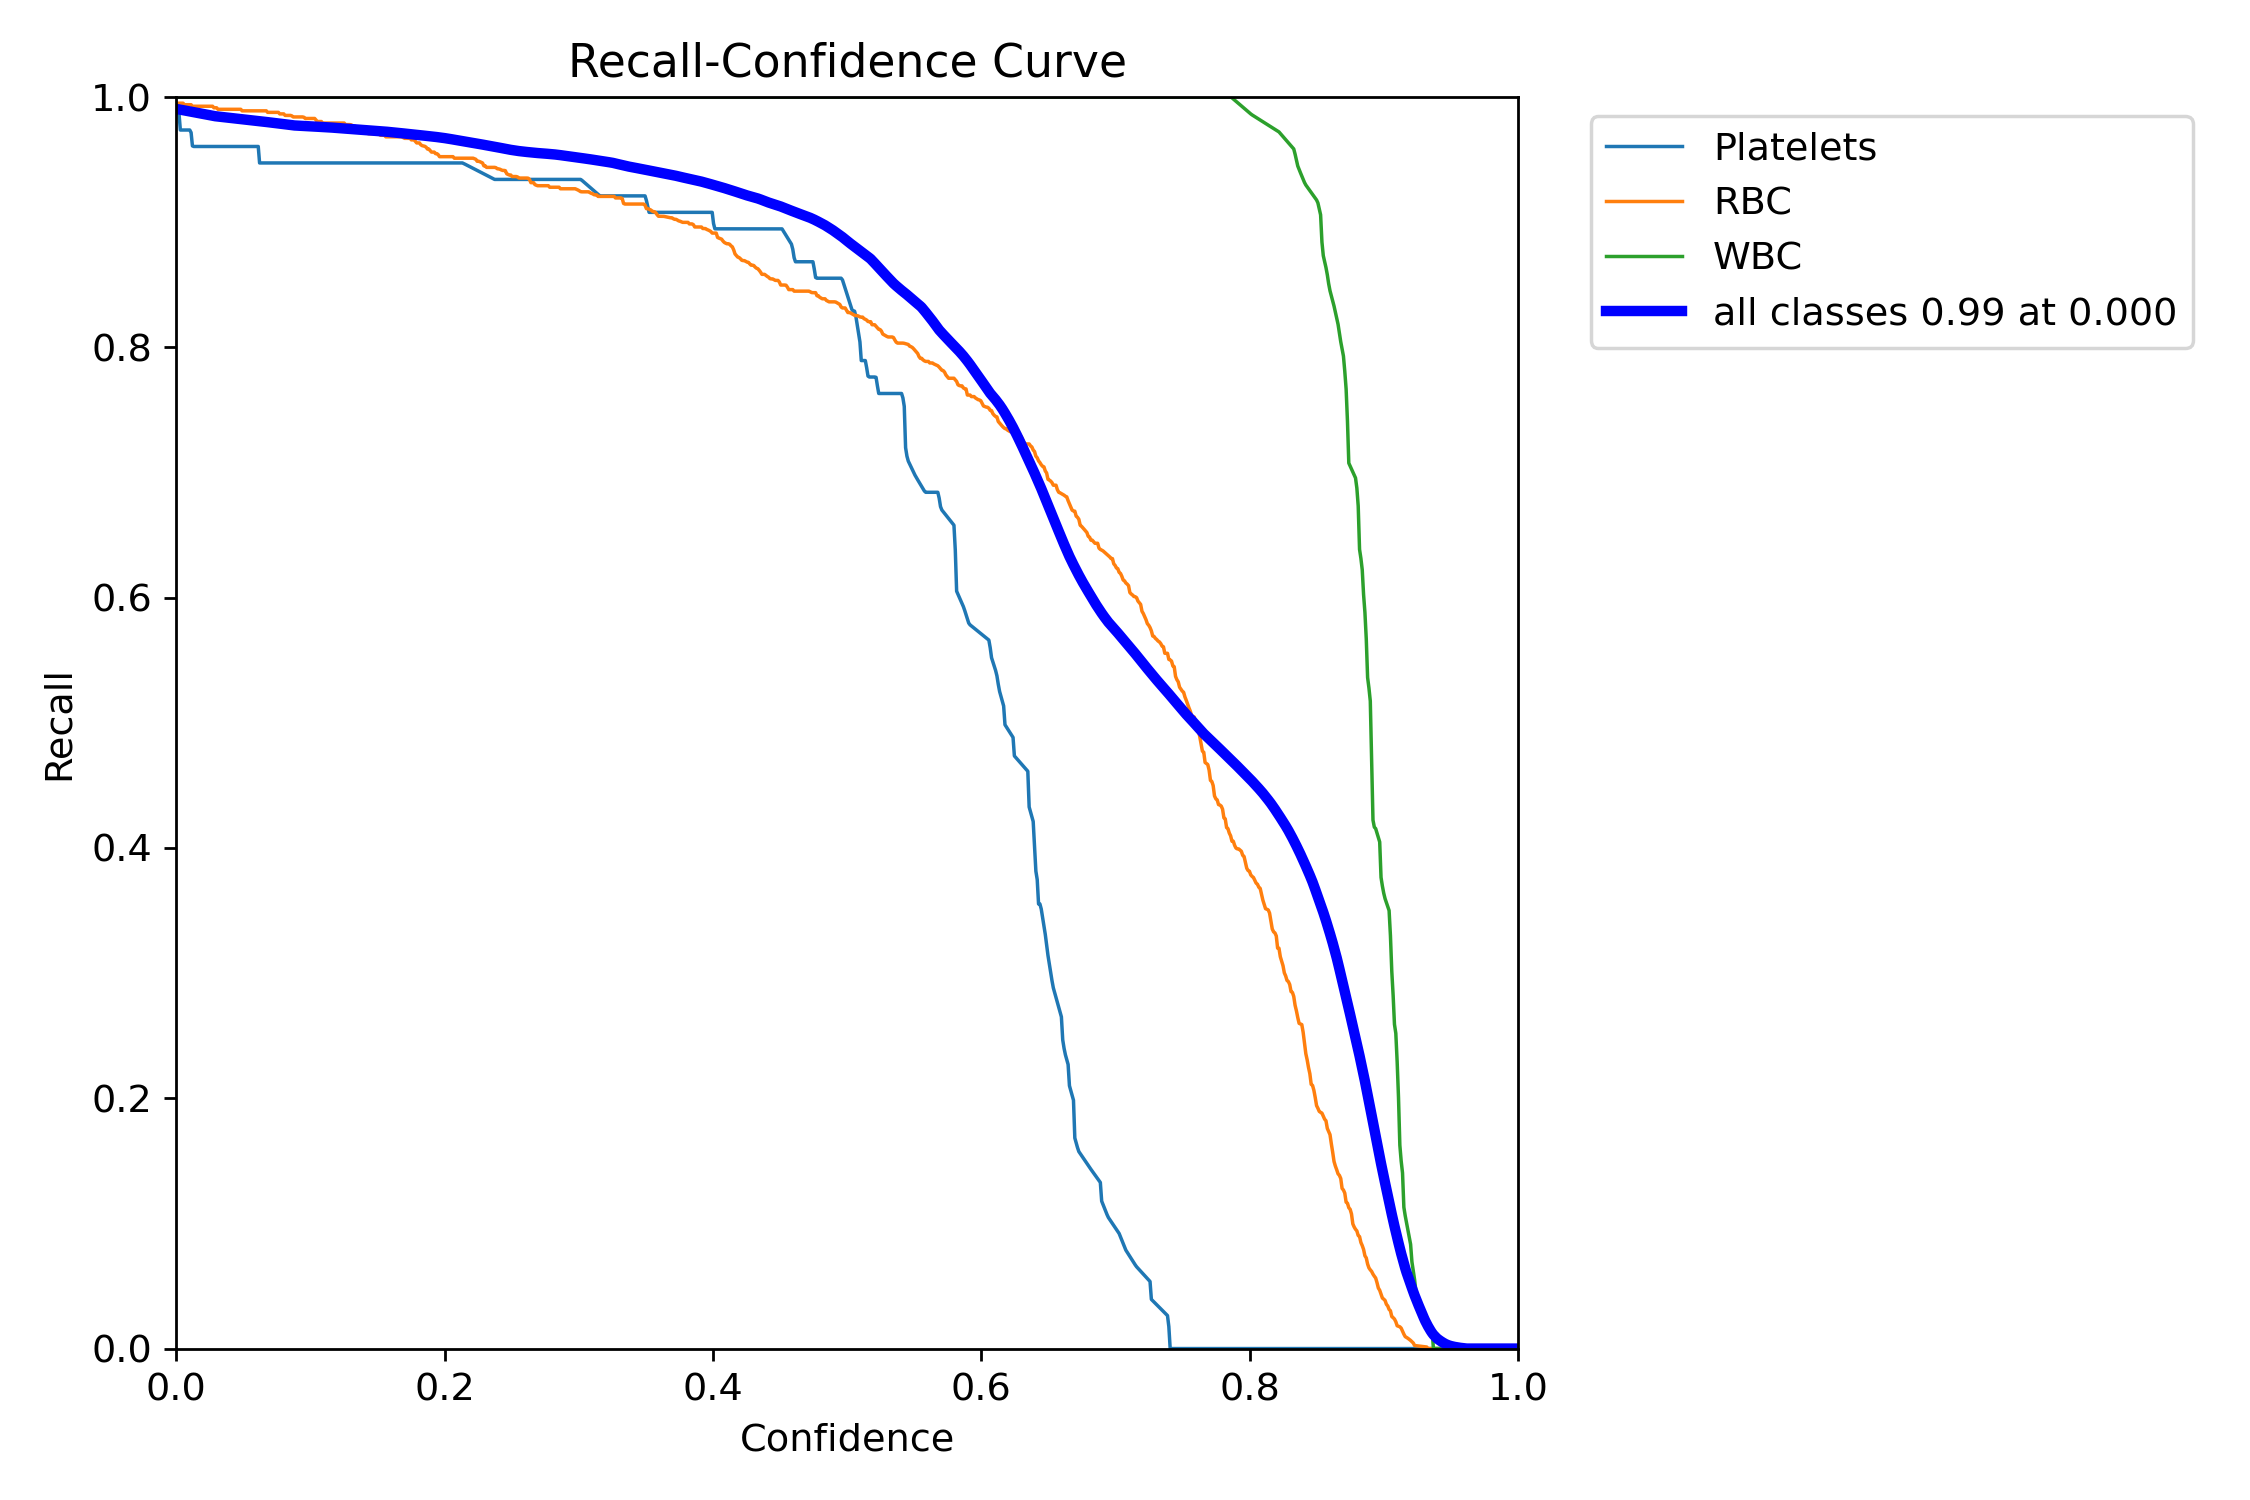

In [ ]:
Image(filename='/content/runs/detect/train/R_curve.png', height=400)

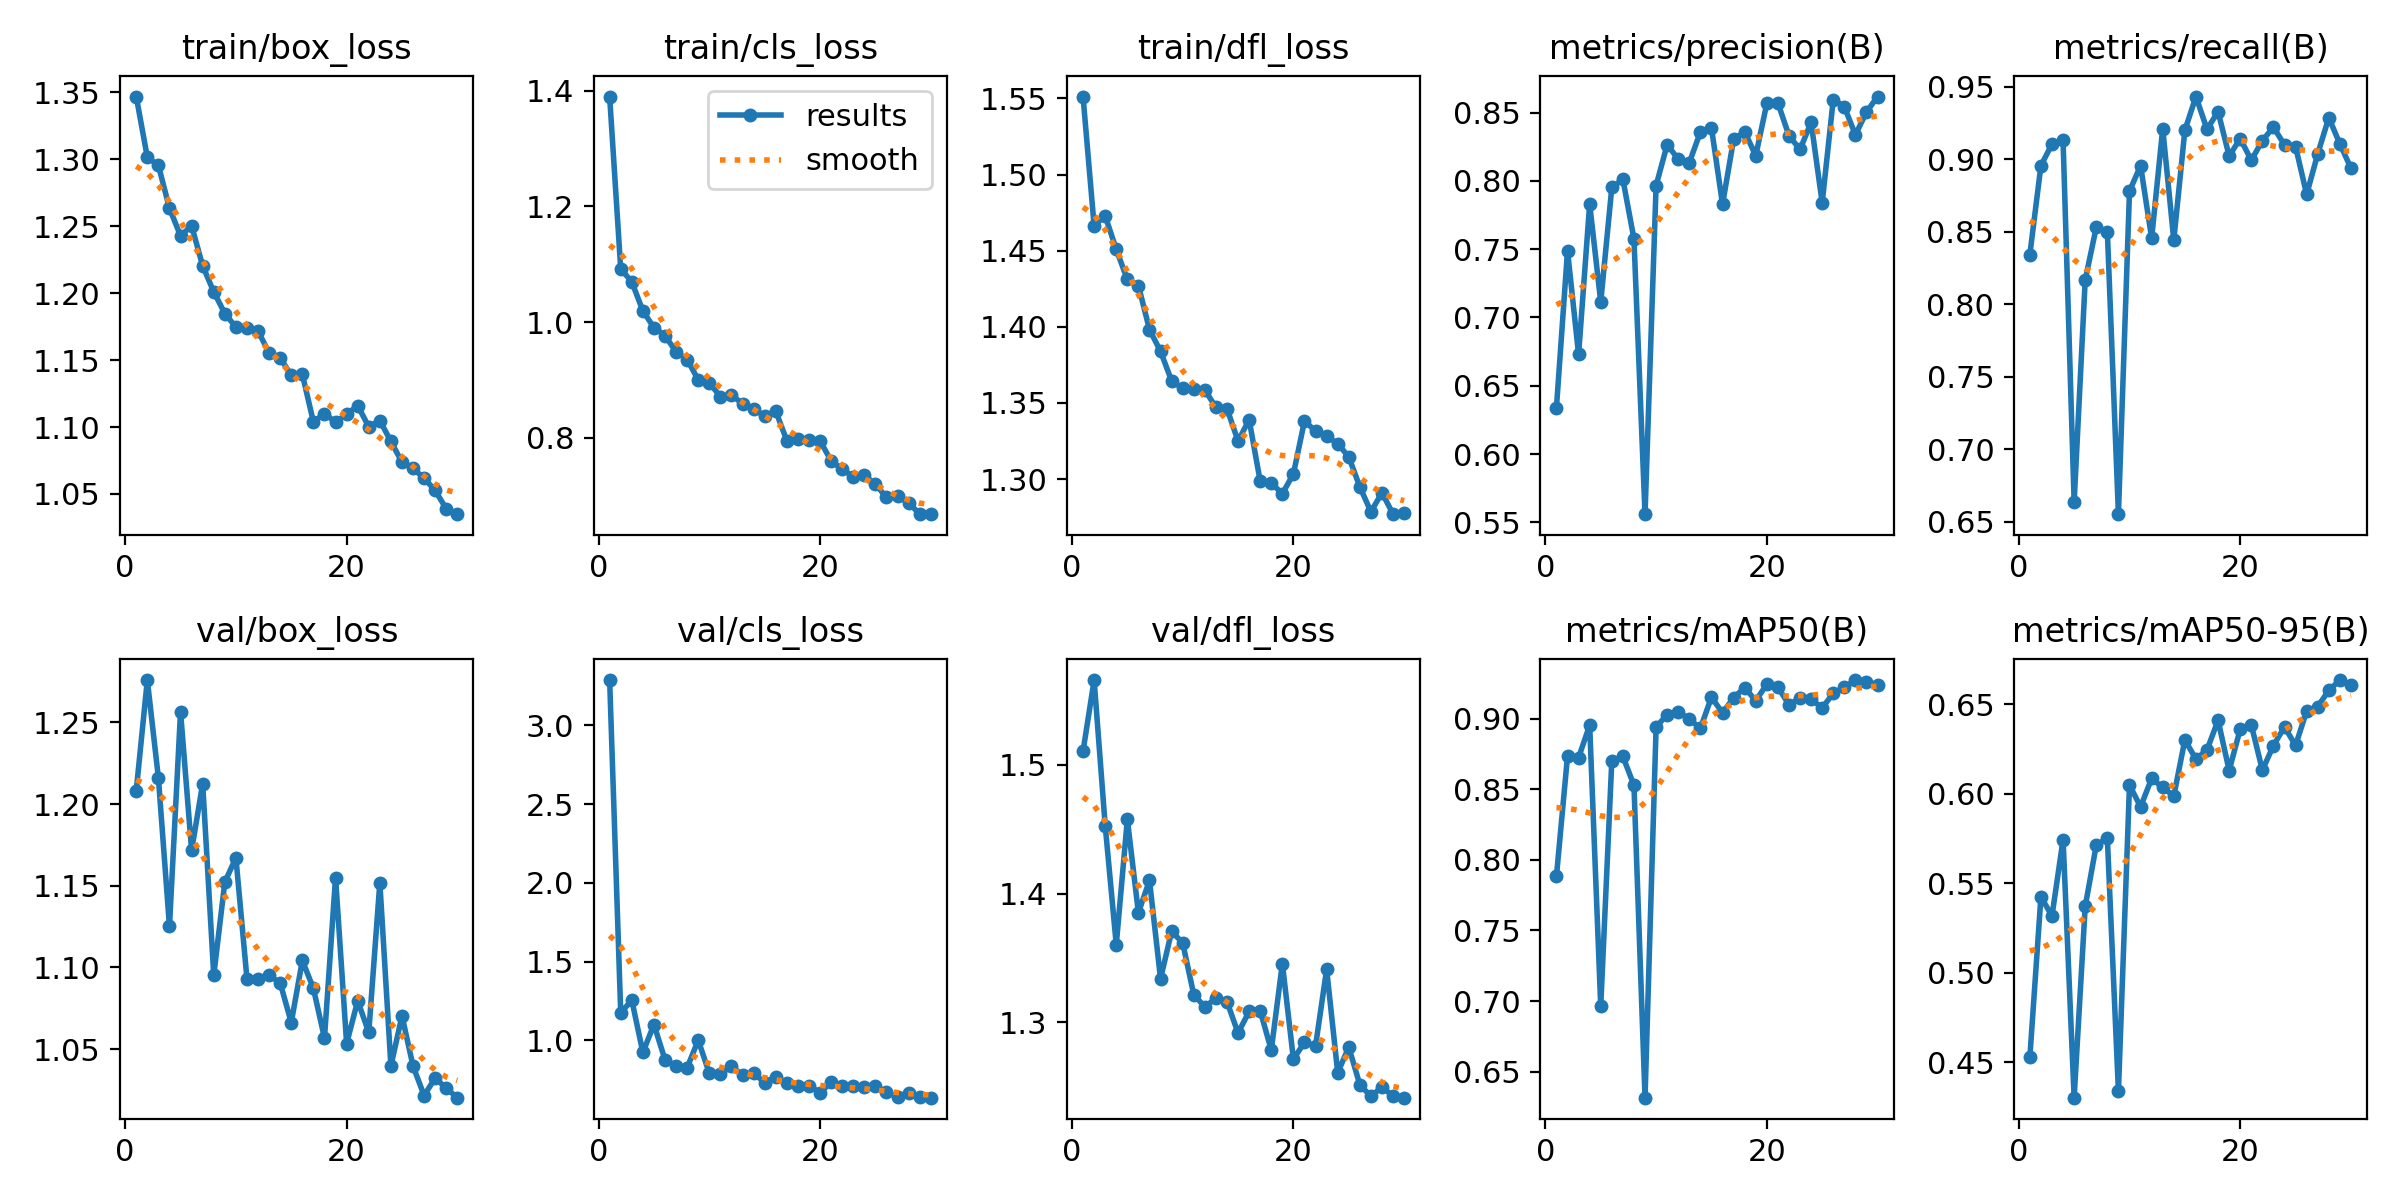

In [ ]:
Image(filename='/content/runs/detect/train/results.png', height=500)

In [ ]:
# %cd /content/yolov5/
# !python train.py --img 640 --epochs 30 --data '/content/data.yaml' --weights yolov5x.pt

/content/yolov5
2023-11-26 15:55:46.030744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 15:55:46.030807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 15:55:46.030847: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5x.pt, cfg=, data=/content/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=Fal